### **Gaussian Beam Profile Extraction**
    Sean Keenan, 5th Year MPhys Heriot-Watt University, Edinburgh
    Quantum memories group - QPL Heriot-Watt

load image files and read camera position data from designated
folder to produce gaussian fit in x and y dimensions. Fit data
can then be plotted against the original image and / or saved
to csv file.

In [44]:
# import relevant modules
import beam_funcs as bf
import fit_funcs as ff
import matplotlib.pyplot as mp
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
from PIL import Image
import sys

# directory and folder for images
folder = 'with lens'
dir = r'C:\Users\sk88\Dropbox (Heriot-Watt University Team)\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\BB Telecom QM\1550 AOM alignment\230421_250mm_collimation'
# image laser wavelength(mm)
ff.wavelength = 1550e-6
# chip and pixel size (mm) if known (Hamamatsu 9.6 x 7.68 mm, DK 1.411cm)
chip_size_x =  9.6
chip_size_y = 7.68
# see curve fit docs for methods
method = 'dogbox'
# tolerance in waist and waist position for fitting
multiplier = 0.5 / 100
# to save data / plots and to show plots
excel_save = False
plot_show = False
plot_save = False
# quick waist calculation - no waist fit / find
quick_show = False
# params for directory interogate
image_exts = ('.tif', '.bmp')
ext = image_exts +  ('.csv', '.xlsx')

Folder to draw files from and save data to

In [45]:
# extract data from folder
folders, files = bf.dir_interogate(path=dir, extensions=ext, folders=folder)
image_files = [i for i in files if i.endswith(image_exts)]
z_file = [ i for i in files if i.endswith('.csv')]
# display error if file incorrect format
if not z_file:
    sys.exit('Excel file does not exist or must be of format ".csv"')
 # warn user if insufficient data to continue
if len(image_files) % 2 != 0:
    sys.exit('Number of image files must be even')
# determine length of arrays needed
array_len = int(len(image_files)/2)
distances = bf.open_excel(os.path.join(folders[0], z_file[0]))
if len(distances) != array_len:
    sys.exit('Number of images and z-distance mismatch')

In [46]:
# determine imag size and calulate pixel dimension (mm)
base_image = Image.open(os.path.join(folders[0], image_files[0]))
im_size = base_image.size
pix_size_x = chip_size_x/ im_size[0]
pix_size_y = chip_size_y/ im_size[1]
# create empty arrays for new data
data = np.empty([array_len, im_size[0], im_size[1]])
fit_data = np.empty([array_len, 2, 3])
fit_err = np.empty([array_len, 2, 3])
# check image type to ensure acurate data processing
im_type = 0
if not base_image.mode in ('I;16', 'L'):
    im_type = 1
# load images and convert to arrays
for index, image_file in enumerate(image_files):
    if index < array_len:
        if im_type == 1:
            beam_image = np.float64(np.transpose(np.asarray(bf.image_read(path=os.path.join(folders[0], image_files[2 * index]), mode='L', convert=1))))
            beam_bkd = np.float64(np.transpose(np.asarray(bf.image_read(path=os.path.join(folders[0], image_file[2 * index+ 1]), mode='L', convert=1))))
        else:
            beam_image = np.float64(np.transpose(np.asarray(bf.image_read(path=os.path.join(folders[0], image_files[2 * index]), convert=0))))
            beam_bkd = np.float64(np.transpose(np.asarray(bf.image_read(path=os.path.join(folders[0], image_files[2 * index + 1]), convert=0))))
        data[index, :, :] = np.absolute(beam_image - beam_bkd)
        data[index, :, :] *= 255/data[index, :, :].max()
        # calculate metadata for gaussian beams
        fit_data[index, :, :], fit_err[index, :, :] = ff.fitgauss(data[index, :, :])

# convert data to mm & remove negatives
scale_data = np.abs(fit_data) * pix_size_x
scale_err = np.abs(fit_err) * pix_size_x
# calcualate percent error
FWHM_err = np.array(scale_err[:, :, 2] / scale_data[:, :, 2])
# calculate FWHM & 1/e^2 (um)
FWHM = 2 * np.sqrt(2 * np.log(2)) * scale_data[:, :, 2]
FWHM_xy = [np.reshape(FWHM[:, 0], (len(FWHM),1)), np.reshape(FWHM[:, 1], (len(FWHM),1))]
FWHM_err = [np.reshape(FWHM_err[:, 0] * np.ravel(FWHM_xy[0]), (len(FWHM),1)), np.reshape(FWHM_err[:, 1] * np.ravel(FWHM_xy[1]),  (len(FWHM),1))]
e2_xy = [FWHM_xy[0] / np.sqrt(2*np.log(2)), FWHM_xy[1] / np.sqrt(2*np.log(2))]
e2_err = [FWHM_err[0] / np.sqrt(2*np.log(2)), FWHM_err[1] / np.sqrt(2*np.log(2))]
# params for fitting to hyperbolic
e2_params = [(np.amin(e2_xy[0]), distances[np.argmin(e2_xy[0])]), (np.amin(e2_xy[1]), distances[np.argmin(e2_xy[1])])]
e2x_lims = ([np.amin(e2_xy[0]) * 1 - multiplier, distances[np.argmin(e2_xy[0])] * 1 - multiplier], [np.amin(e2_xy[0]) * 1 + multiplier, distances[np.argmin(e2_xy[0])] * 1 + multiplier])
# find the fit parameters for the hyerbolic function
e2x, e2x_err = ff.fithyp(distances, np.ravel(e2_xy[0]), e2_params[0], meth=method, lims=e2x_lims)
e2y, e2y_err = ff.fithyp(distances, np.ravel(e2_xy[1]), e2_params[1], meth=method)
# calculate rayleigh range and divergence angle
zr = [(np.pi * 1.0003 * e2x[0] ** 2)/ff.wavelength, (np.pi * 1.0003 * e2x[0] ** 2)/ff.wavelength]
theta = [(ff.wavelength / (np.pi *1.0003 * e2y[0])) * (180/np.pi), (ff.wavelength / (np.pi * 1.0003 * e2y[0])) * (180/np.pi)]
# print out waist values and rayleigh range
print('x 1/e^2 waist = ' + '%.2f ' % e2x[0] + 'p/m ' + '%.2f mm' % e2x_err[0] + ' located at ' + '%.2f' % (e2x[1])+ ' p/m ' + '%.2f mm' % (e2x_err[1]))
print('y 1/e^2 waist = ' + '%.2f ' % e2y[0] + 'p/m ' + '%.2f mm' % e2y_err[0] + ' located at ' + '%.2f' % (e2y[1])+ ' p/m ' + '%.2f mm' % (e2y_err[1]))
print('x rayleigh range = ' + '%.2f mm ' % zr[0] + 'with divergence angle = ' + '%.2f deg' % theta[0])
print('y rayleigh range = ' + '%.2f mm ' % zr[1] + 'with divergence angle = ' + '%.2f deg' % theta[1])

x 1/e^2 waist = 0.26 p/m 0.03 mm located at 200.00 p/m 21.72 mm
y 1/e^2 waist = 0.28 p/m 0.02 mm located at 211.01 p/m 12.47 mm
x rayleigh range = 141.15 mm with divergence angle = 0.10 deg
y rayleigh range = 141.15 mm with divergence angle = 0.10 deg


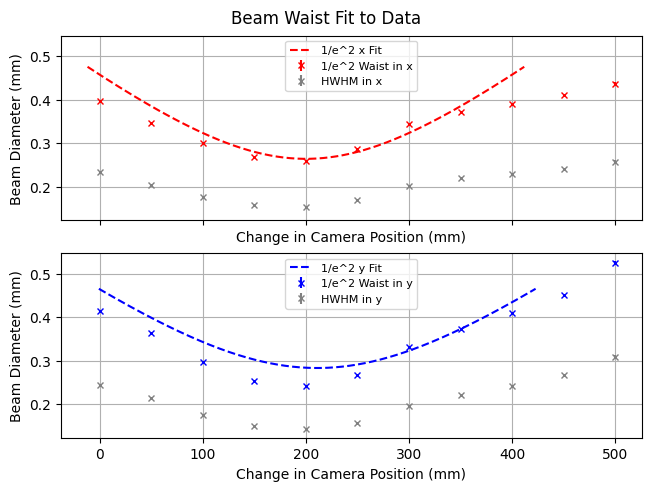

In [47]:
# set up x values for plotting
zx_plot = np.linspace(start=-1.5 * zr[0], stop = 1.5*zr[0], num=1000, endpoint=True) + e2x[1]
zy_plot = np.linspace(start=-1.5 * zr[1], stop = 1.5*zr[1], num=1000, endpoint=True) + e2y[1]
# set up figure space for error bars and hyperbolic fit
fig_1, ax_1 = mp.subplots(nrows=2, ncols=1, sharex='all', sharey='all', constrained_layout=True)
# real beam data plots 1/e^2 (x & y)
ax_1[0].errorbar(distances, e2_xy[0].flatten(), yerr = e2_err[0].flatten(), label='1/e^2 Waist in x', markersize=5, color='red', fmt='x')
ax_1[1].errorbar(distances, e2_xy[1].flatten(), yerr = e2_err[1].flatten(), label='1/e^2 Waist in y', markersize=5, color='blue', fmt='x')
# real beam data plots FWHM (x & y)
ax_1[0].errorbar(distances, 0.5 * FWHM_xy[0].flatten(), yerr = FWHM_err[0].flatten(), label='HWHM in x', markersize=5, color='grey', fmt='x')
ax_1[1].errorbar(distances, 0.5 * FWHM_xy[1].flatten(), yerr = FWHM_err[1].flatten(), label='HWHM in y', markersize=5, color='grey', fmt='x')
# hyperbolic fit (x & y)
ax_1[0].plot(zx_plot, ff.hyperbolic(zx_plot, e2x[0], e2x[1]), linestyle='--', label='1/e^2 x Fit', color='red')
ax_1[1].plot(zy_plot, ff.hyperbolic(zy_plot, e2y[0], e2y[1]), linestyle='--', label='1/e^2 y Fit', color='blue')

# format plots
fig_1.suptitle('Beam Waist Fit to Data')
for ax in ax_1:
    ax.set(xlabel='Change in Camera Position (mm)', ylabel='Beam Diameter (mm)')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True)    

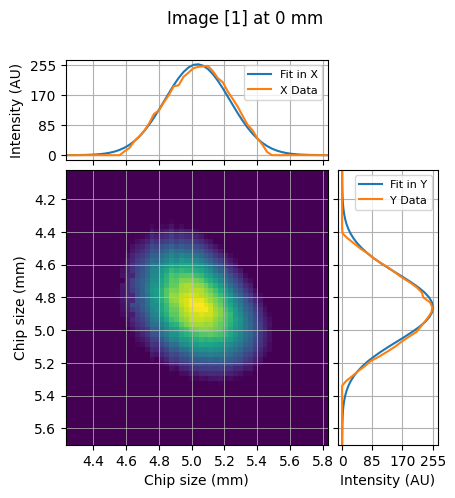

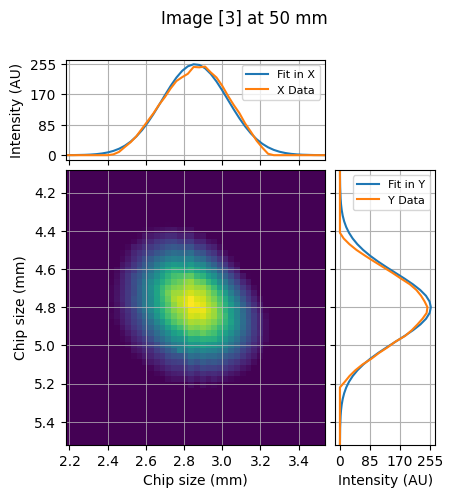

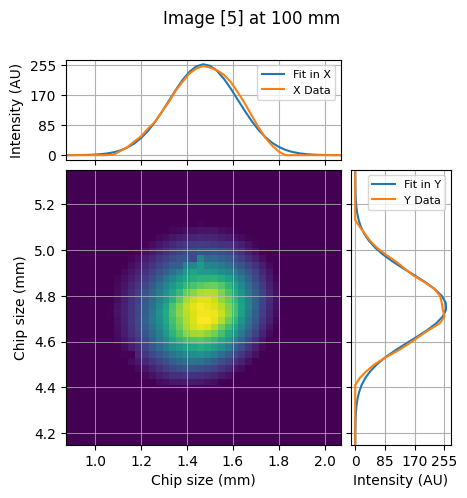

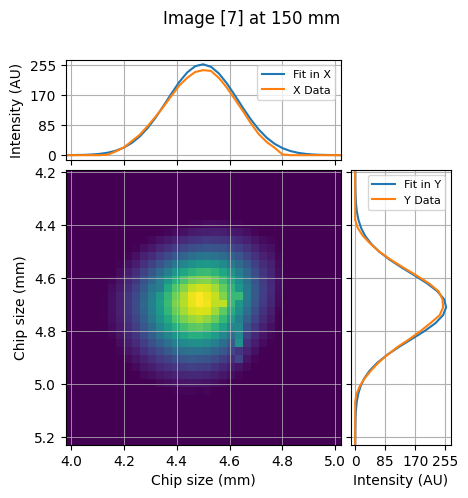

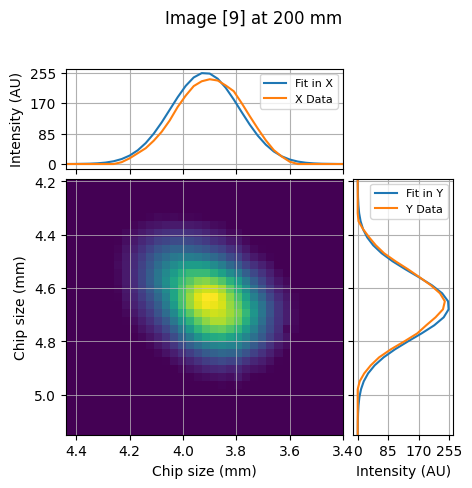

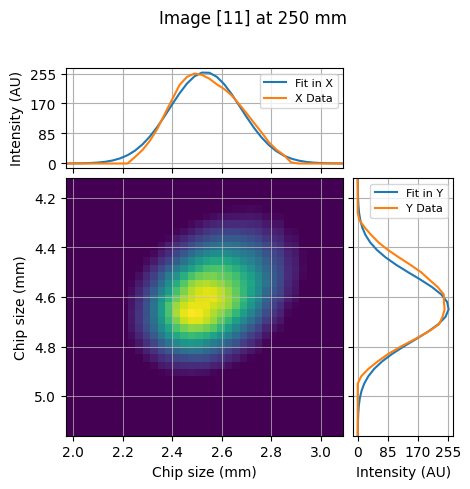

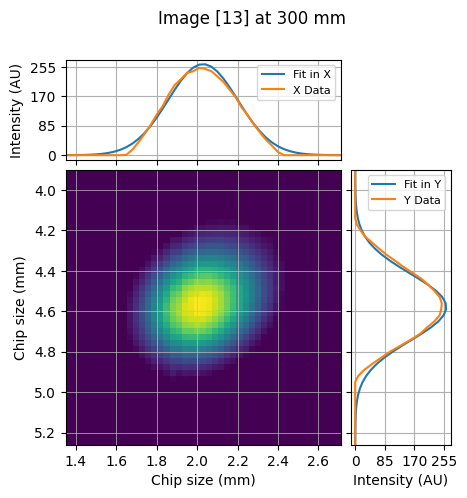

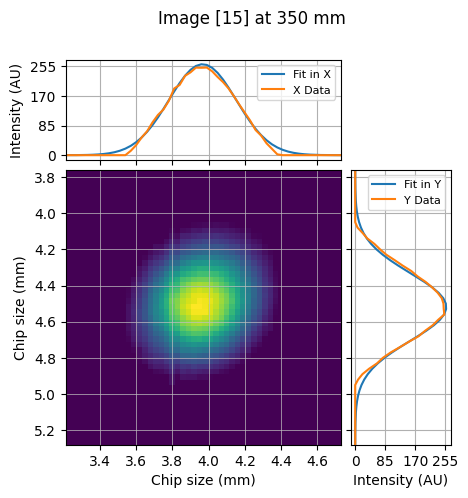

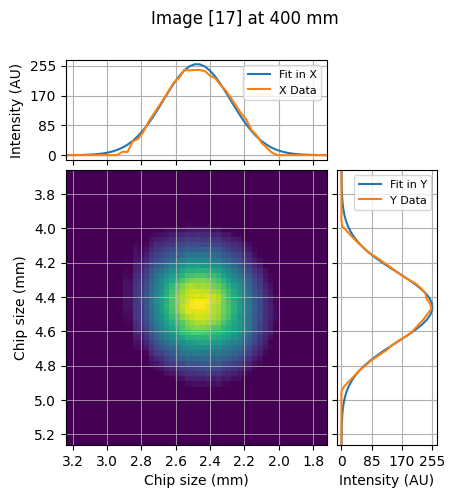

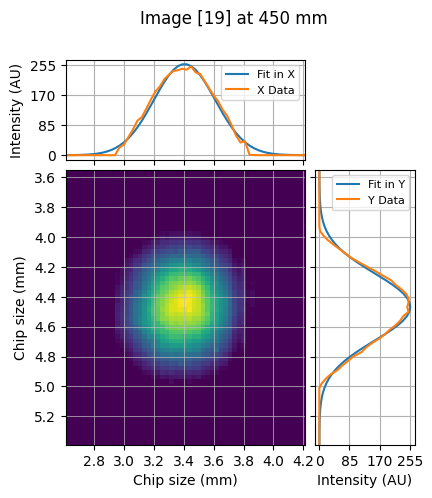

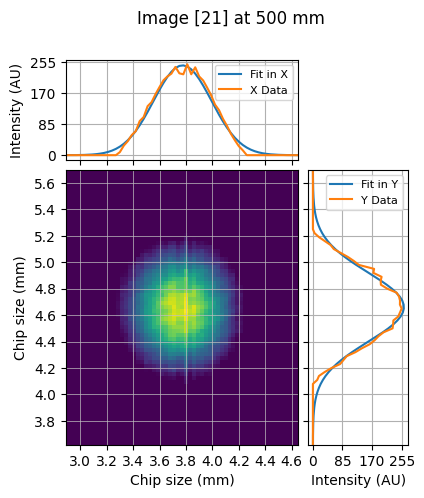

In [48]:
# array for fit to data
x = np.arange(1, im_size[0] + 1, 1)
y = np.arange(1, im_size[1] + 1, 1)

img_idx = (np.arange(1, len(image_files), 2)).reshape(len(FWHM),1)

# plot gaussian fit to data  
for index in range(array_len):
    
    # define figure and axes
    fig_2, ax_2 = mp.subplots(figsize=(5, 5))
    # main figure original image
    ax_2.imshow(np.transpose(data[index,: , :]), extent=[0, pix_size_x * im_size[0], pix_size_y * im_size[1], 0])
    # add top and left subplots
    divider = make_axes_locatable(ax_2)
    ax_fitx = divider.append_axes("top", 1, pad=0.1, sharex=ax_2)
    ax_fity = divider.append_axes("right", 1, pad=0.1, sharey=ax_2)
    # remove corresponding axes labels
    ax_fitx.xaxis.set_tick_params(labelbottom=False)
    ax_fity.yaxis.set_tick_params(labelleft=False)
    # plot data
    ax_fitx.plot(x * pix_size_x, ff.gaussian(x, *fit_data[index, 0, :]), label='Fit in X')
    ax_fitx.plot(x * pix_size_x, data[index, :, round(fit_data[index, 1, 1])], label='X Data')
    ax_fity.plot(ff.gaussian(y, *fit_data[index, 1, :]), y * pix_size_y, label='Fit in Y')
    ax_fity.plot(data[index, round(fit_data[index, 0, 1]), :], y * pix_size_y, label='Y Data')
    # axis label formatting
    ticks = np.linspace(start=0, stop=np.max(data[index]), num=4)
    ax_fitx.set_yticks(ticks)
    ax_fity.set_xticks(ticks)
    ax_2.set_xticks(np.arange(0, im_size[0] * pix_size_x, 0.2))
    ax_2.set_yticks(np.arange(0, im_size[1] * pix_size_y, 0.2))
    # set limits
    llim = round(fit_data[index, 0, 1] * pix_size_x, ndigits=2) - 4 * round(fit_data[index, 0, 2] * pix_size_x, ndigits=2)
    rlim = round(fit_data[index, 0, 1] * pix_size_x, ndigits=2) + 4 * round(fit_data[index, 0, 2] * pix_size_x, ndigits=2)
    tlim = round(fit_data[index, 1, 1] * pix_size_y, ndigits=2) - 4 * round(fit_data[index, 1, 2] * pix_size_y, ndigits=2)
    blim = round(fit_data[index, 1, 1] * pix_size_y, ndigits=2) + 4 * round(fit_data[index, 1, 2] * pix_size_y, ndigits=2)
    ax_2.set_xlim(left=llim, right=rlim)
    ax_2.set_ylim(top=tlim, bottom=blim)
    # add grid lines
    ax_fitx.grid(True)
    ax_fity.grid(True)
    ax_2.grid(True, color='silver', linewidth=0.5)
    # format labels
    ax_2.set(xlabel='Chip size (mm)', ylabel='Chip size (mm)')
    ax_fitx.set(ylabel='Intensity (AU)')
    ax_fity.set(xlabel='Intensity (AU)')
    if quick_show == 0:
        fig_2.suptitle('Image ' + str(img_idx[index]) + ' at ' + str((distances[index])) + ' mm')
    else:
        fig_2.suptitle('Image ' + str(img_idx[index]) + ' waist ' + str((e2_xy[0][index])) + ' mm')

    ax_fitx.legend(loc='best', fontsize=8)
    ax_fity.legend(loc='best', fontsize=8)

    if plot_save == True:
        fig_1.savefig(fname=dir + folder + '_' + 'beam_waist_fit', dpi=80, format='png')
        fig_2.savefig(fname=dir + folder + '_' + str(img_idx[index]) + 'fit.pdf', dpi='figure', format='pdf')

if plot_show == True:
    mp.show()